# Shor's Algorithm for Factorization of Integers

Given a large number $N$, say with at least 100 digits, how can we find a factor of $N$? There are several famous classical algorithms, and [Wikipedia](https://en.wikipedia.org/wiki/Integer_factorization) contains an exhaustive list of these algorithms. The best known algorithm for huge integers is the _general field sieve_ algorithm, which has a runtime of $\exp(O(\ln N)^{1/3}(\ln\ln N)^{2/3})$.

Factorization is definitely a hard problem, but it is not known whether it can be solved in $\text{poly}(n)$ time (where $n = \lceil\log_2 N\rceil$). It is widely assumed that Factorization is not in $P$, and this is the base of cryptographic protocols such as RSA that are in use today.

Shor's algorithm provides a fast quantum solution to the factoring problem (in time polynomial in the number of input bits), and we shall see in this tutorial how exactly it finds factors of composite numbers.

## Part I: Reduction of Factorization to Order-finding

Let us start by picking an $x$ uniformly at random from $\{2,\ldots, N-1\}$. The [Euclidean Algorithm](http://www-math.ucdenver.edu/~wcherowi/courses/m5410/exeucalg.html) is able to determine $\text{gcd}(x,N)$ efficiently. If $\text{gcd}(x,N)\neq 1$, we were lucky and already find a factor of $N$! Otherwise, there's more work left...

Let $r\ge 1$ be the smallest integer (known as the *order*) such that $x^r\equiv 1 \mod N$. If $r$ is even, we know that
$$ (x^{r/2}-1)(x^{r/2}+1)\equiv 0 \mod N,$$
implying $\text{gcd}(x^{r/2}-1, N)$ or $\text{gcd}(x^{r/2}+1, N)$ will give a factor $d$ of $N$. We can then run the same order-finding algorithm recursively on $N/d$.

Thus, if we have an efficient way of calculating $r = A(x,N)$, the order of $x$ modulo $N$, we can solve the factorization problem as follows:

> factorize($N$):
> + pick $x$ uniformly at random from $\{2,\ldots,N-1\}$.
> + if $d = \text{gcd}(x,N)\neq 1$, return $d$ as a factor and run _factorize($N/d$)_.
> + else:
>     - let $r = A(x,N)$. 
>     - if $r$ is even, $\text{gcd}(x^{r/2}-1, N)$ or $\text{gcd}(x^{r/2}+1, N)$ will give a factor $d$. return $d$ and run _factorize($N/d$)_.
>     - else pick another $x$ uniformly at random and repeat.

## Part II: Finding the order
In order to compute the value of $r = A(x,n)$, we shall first require a unitary operator $U_x$ such that
$$U_x\lvert j\rangle_t \lvert k\rangle_n = \lvert j\rangle_t \lvert k\oplus (x^j\mbox{ mod } N)\rangle_n.$$

Then, we consider the following circuit with Register 1 of $t$ qubits and Register 2 of $n$ qubits:

<img src="./img/104_shor_ckt.png" alt="shor-circuit" width="600"/>

Here $n=\lceil \log_2N\rceil$ and $t=\lceil 2\log_2 N\rceil$ in general. The choice of $t$ can be simplified to $t=n=\lceil \log_2N\rceil$ if $r=A(x,n)$ is a power of $2$. We shall consider this special case first.

### Case 1: Order is a power of 2
Then, after the initialization we obtain the state

$$\varphi_1 = \frac 1{\sqrt{2^t}}\sum_{j=0}^{2^t-1}\lvert j\rangle \lvert 0\rangle,$$

And therefore,

$$\varphi_2 = U_x\varphi_1 = \frac 1{\sqrt{2^t}}\sum_{j=0}^{2^t-1}\lvert j\rangle \lvert x^j\mbox{ mod }N\rangle.$$

$\varphi_2$ could be thought of as an encoding of all $x^j\mbox{ mod }N$ calculated for each integer $j<2^t$, and we would be interested in finding the smallest $j$ for which $x^j\mbox{ mod }N=1$.

For simplicity of calculations, we first measure the second register. Note that as every $j$ can be written as

$$ j = ar+b, \mbox{ where }0\le a < 2^t/r \mbox{ and } 0\le b <r,$$

we can then write $\varphi_2$ as the following double sum:

$$\varphi_2 = \frac 1{\sqrt{2^t}}\sum_{b=0}^{r-1}\sum_{a=0}^{2^t/r -1}\lvert ar+b\rangle\lvert x^{ar+b}\mbox{ mod }N\rangle.$$

Note that $x^{ar+b}\mbox{ mod }N = x^b\mbox{ mod }N$. Also, recall that $2^t/r$ is an integer since $r$ is a power of $2$ in this case. Thus, we can finally write

$$\varphi_2 = \frac 1{\sqrt{2^t}}\sum_{b=0}^{r-1}\sum_{a=0}^{2^t/r -1}\lvert ar+b\rangle\lvert x^{b}\mbox{ mod }N\rangle.$$

Now we measure the second register. Each choice $x^0, \ldots, x^{r-1}$ are equally probably to be measured. Say the output of the measurement is $x^{b_0}$, then $\varphi_2$ ends up in the following state:

$$\varphi_3 = \frac{\sqrt r}{\sqrt{2^t}}\sum_{a=0}^{2^t/r - 1} \lvert ar+b_0\rangle \lvert x^{b_0}\mbox{ mod }N \rangle.$$

Now the only uncertainty is in the first register, and if measured, we'll see a probability of $r/2^t$ of each state $\lvert ar+b_0\rangle, 0\le a<2^t/r$ to be measured. Finally, we apply inverse QFT on the first register. Recall that we already covered the action of $\mbox{QFT}$ and $\mbox{QFT}^\dagger$, and this lets us compute the final quantum state of the circuit as follows:

$$
\begin{aligned}\varphi_4 &= \frac{\sqrt{r}}{\sqrt{2^t}} \sum_{a=0}^{2^t/r-1}\left[\frac1{\sqrt{2^t}}\sum_{j=0}^{2^t-1}\exp\left(\frac{-2\pi i j(ar+b_0)}{2^r}\right)\lvert j\rangle \right]\lvert x^{b_0}\mbox{ mod }N \rangle\\
& = \frac1{\sqrt r}\left[\sum_{j=0}^{2^t-1}\left(\frac r{2^t}\sum_{a=0}^{2^t/r-1}\exp\left(\frac{-2\pi ija}{2^t/r}\right) \right)\exp\left(\frac{-2\pi ijb_0}{2^t}\right)\lvert j\rangle\right]\lvert x^{b_0}\mbox{ mod }N \rangle\end{aligned}.$$

Using the Fourier identity $\frac 1N\sum_{j=0}^{N-1} \exp(2\pi ijk/N) = 1$ if $k$ is a multiple of $N$ and $0$ otherwise, we see that the expression in the inner parentheses is $0$ most of the time. Only when $j$ is a multiple of $2^t/r$, we obtain a nonzero expression. Thus,

$$\varphi_4 = \frac 1{\sqrt r}\sum_{k=0}^{r-1}\exp\left(\frac{-2\pi ikb_0}r\right) \lvert k2^t/r\rangle \lvert x^{b_0}\mbox{ mod }N\rangle.$$

The measurement outcomes from measuring $\varphi_4$ therefore are $k2^t/r$, for $0\le k \le r-1$.

Let us now measure $\varphi_4$. We now do the following steps with the outcome $B = k_02^t/r$.

+ If the outcome $B$ is $0$, then we obtain no information about $r$, and will run our circuit again. 
+ If we $B = k_02^t/r$ for some $0 < k_0\le r-1$, compute $k_0/r = B/2^t$. We then know that the denominator of $B/2^t$ _divides_ $r$. 
  - Let $r_1$ be the denominator. If $x^{r_1}\mbox{ mod }N = 1$, $r_1$ is the order, and we can stop.
  - Otherwise, Let $r_2 = r/r_1$. Note that $r_2$ is the order of $x^{r_1}$, and we run the algorithm again to find the order of $x^{r_1}$. We apply the algorithm recursively until we find the entire order $r$.
  
This is the full description of Shor's algorithm. Although technical, it's an efficient algorithm with clear basic steps. For now, we postpone the discussion of Case 2 to a later section.

### Implementation of Shor's Algorithm for Case 1
Let us now implement Shor's Algorithm to factorize $N=15$. We choose $15$ since the orders of the numbers $\{1,2,4,7,8,11,13,14\}$ which are less than $15$ and coprime to $15$ are all $2$ or $4$, leading to an ideal circuit for us.

Recall that we need $t=4$ qubits in the first register and $n=4$ qubits in the second register!
We shall now focus on finding the order of $7$ modulo $15$.

### Implementing $U_x$
One of the main challenges in implementing Shor's algorithm is to create the circuit $U_x$ using physical gates. We take the implementation for $x^b\mbox{ mod }N$ for $N=15$ from [Markov-Saeedi](https://arxiv.org/pdf/1202.6614.pdf).

In [1]:
# Install blueqat!
# !pip install blueqat

# Import libraries
from blueqat import Circuit
import numpy as np

# Recall QFT dagger from our previous tutorial
def apply_qft_dagger(circuit: Circuit(), qubits):
    num_qubits = len(qubits)
    # Reverse the order of qubits at the end
    for i in range(int(num_qubits/2)):
        circuit.swap(qubits[i],qubits[num_qubits-i-1])
    for i in range(num_qubits):
        for j in range(i):
            circuit.cphase(-np.pi/(2 ** (j-i)))[qubits[j],qubits[i]]
        circuit.h[qubits[i]]

In [2]:
# Implementation of U_x as a black box. More details can be found in the previously mentioned paper.
def apply_U_7_mod15(circuit: Circuit(), qubits):
    assert len(qubits) == 8, 'Must have 8 qubits as input.'
    circuit.x[qubits[7]]
    circuit.ccx[qubits[0],qubits[6],qubits[7]]
    circuit.ccx[qubits[0],qubits[7],qubits[6]]
    circuit.ccx[qubits[0],qubits[6],qubits[7]]
    circuit.ccx[qubits[0],qubits[5],qubits[6]]
    circuit.ccx[qubits[0],qubits[6],qubits[5]]
    circuit.ccx[qubits[0],qubits[5],qubits[6]]
    circuit.ccx[qubits[0],qubits[4],qubits[5]]
    circuit.ccx[qubits[0],qubits[5],qubits[4]]
    circuit.ccx[qubits[0],qubits[4],qubits[5]]
    circuit.cx[qubits[0],qubits[4]]
    circuit.cx[qubits[0],qubits[5]]
    circuit.cx[qubits[0],qubits[6]]
    circuit.cx[qubits[0],qubits[7]]
    circuit.ccx[qubits[1],qubits[6],qubits[7]]
    circuit.ccx[qubits[1],qubits[7],qubits[6]]
    circuit.ccx[qubits[1],qubits[6],qubits[7]]
    circuit.ccx[qubits[1],qubits[5],qubits[6]]
    circuit.ccx[qubits[1],qubits[6],qubits[5]]
    circuit.ccx[qubits[1],qubits[5],qubits[6]]
    circuit.ccx[qubits[1],qubits[4],qubits[5]]
    circuit.ccx[qubits[1],qubits[5],qubits[4]]
    circuit.ccx[qubits[1],qubits[4],qubits[5]]
    circuit.cx[qubits[1],qubits[4]]
    circuit.cx[qubits[1],qubits[5]]
    circuit.cx[qubits[1],qubits[6]]
    circuit.cx[qubits[1],qubits[7]]
    circuit.ccx[qubits[1],qubits[6],qubits[7]]
    circuit.ccx[qubits[1],qubits[7],qubits[6]]
    circuit.ccx[qubits[1],qubits[6],qubits[7]]
    circuit.ccx[qubits[1],qubits[5],qubits[6]]
    circuit.ccx[qubits[1],qubits[6],qubits[5]]
    circuit.ccx[qubits[1],qubits[5],qubits[6]]
    circuit.ccx[qubits[1],qubits[4],qubits[5]]
    circuit.ccx[qubits[1],qubits[5],qubits[4]]
    circuit.ccx[qubits[1],qubits[4],qubits[5]]
    circuit.cx[qubits[1],qubits[4]]
    circuit.cx[qubits[1],qubits[5]]
    circuit.cx[qubits[1],qubits[6]]
    circuit.cx[qubits[1],qubits[7]]
    circuit.ccx[qubits[2],qubits[6],qubits[7]]
    circuit.ccx[qubits[2],qubits[7],qubits[6]]
    circuit.ccx[qubits[2],qubits[6],qubits[7]]
    circuit.ccx[qubits[2],qubits[5],qubits[6]]
    circuit.ccx[qubits[2],qubits[6],qubits[5]]
    circuit.ccx[qubits[2],qubits[5],qubits[6]]
    circuit.ccx[qubits[2],qubits[4],qubits[5]]
    circuit.ccx[qubits[2],qubits[5],qubits[4]]
    circuit.ccx[qubits[2],qubits[4],qubits[5]]
    circuit.cx[qubits[2],qubits[4]]
    circuit.cx[qubits[2],qubits[5]]
    circuit.cx[qubits[2],qubits[6]]
    circuit.cx[qubits[2],qubits[7]]
    circuit.ccx[qubits[2],qubits[6],qubits[7]]
    circuit.ccx[qubits[2],qubits[7],qubits[6]]
    circuit.ccx[qubits[2],qubits[6],qubits[7]]
    circuit.ccx[qubits[2],qubits[5],qubits[6]]
    circuit.ccx[qubits[2],qubits[6],qubits[5]]
    circuit.ccx[qubits[2],qubits[5],qubits[6]]
    circuit.ccx[qubits[2],qubits[4],qubits[5]]
    circuit.ccx[qubits[2],qubits[5],qubits[4]]
    circuit.ccx[qubits[2],qubits[4],qubits[5]]
    circuit.cx[qubits[2],qubits[4]]
    circuit.cx[qubits[2],qubits[5]]
    circuit.cx[qubits[2],qubits[6]]
    circuit.cx[qubits[2],qubits[7]]
    circuit.ccx[qubits[2],qubits[6],qubits[7]]
    circuit.ccx[qubits[2],qubits[7],qubits[6]]
    circuit.ccx[qubits[2],qubits[6],qubits[7]]
    circuit.ccx[qubits[2],qubits[5],qubits[6]]
    circuit.ccx[qubits[2],qubits[6],qubits[5]]
    circuit.ccx[qubits[2],qubits[5],qubits[6]]
    circuit.ccx[qubits[2],qubits[4],qubits[5]]
    circuit.ccx[qubits[2],qubits[5],qubits[4]]
    circuit.ccx[qubits[2],qubits[4],qubits[5]]
    circuit.cx[qubits[2],qubits[4]]
    circuit.cx[qubits[2],qubits[5]]
    circuit.cx[qubits[2],qubits[6]]
    circuit.cx[qubits[2],qubits[7]]
    circuit.ccx[qubits[2],qubits[6],qubits[7]]
    circuit.ccx[qubits[2],qubits[7],qubits[6]]
    circuit.ccx[qubits[2],qubits[6],qubits[7]]
    circuit.ccx[qubits[2],qubits[5],qubits[6]]
    circuit.ccx[qubits[2],qubits[6],qubits[5]]
    circuit.ccx[qubits[2],qubits[5],qubits[6]]
    circuit.ccx[qubits[2],qubits[4],qubits[5]]
    circuit.ccx[qubits[2],qubits[5],qubits[4]]
    circuit.ccx[qubits[2],qubits[4],qubits[5]]
    circuit.cx[qubits[2],qubits[4]]
    circuit.cx[qubits[2],qubits[5]]
    circuit.cx[qubits[2],qubits[6]]
    circuit.cx[qubits[2],qubits[7]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[7],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[4]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.cx[qubits[3],qubits[4]]
    circuit.cx[qubits[3],qubits[5]]
    circuit.cx[qubits[3],qubits[6]]
    circuit.cx[qubits[3],qubits[7]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[7],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[4]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.cx[qubits[3],qubits[4]]
    circuit.cx[qubits[3],qubits[5]]
    circuit.cx[qubits[3],qubits[6]]
    circuit.cx[qubits[3],qubits[7]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[7],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[4]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.cx[qubits[3],qubits[4]]
    circuit.cx[qubits[3],qubits[5]]
    circuit.cx[qubits[3],qubits[6]]
    circuit.cx[qubits[3],qubits[7]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[7],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[4]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.cx[qubits[3],qubits[4]]
    circuit.cx[qubits[3],qubits[5]]
    circuit.cx[qubits[3],qubits[6]]
    circuit.cx[qubits[3],qubits[7]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[7],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[4]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.cx[qubits[3],qubits[4]]
    circuit.cx[qubits[3],qubits[5]]
    circuit.cx[qubits[3],qubits[6]]
    circuit.cx[qubits[3],qubits[7]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[7],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[4]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.cx[qubits[3],qubits[4]]
    circuit.cx[qubits[3],qubits[5]]
    circuit.cx[qubits[3],qubits[6]]
    circuit.cx[qubits[3],qubits[7]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[7],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[4]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.cx[qubits[3],qubits[4]]
    circuit.cx[qubits[3],qubits[5]]
    circuit.cx[qubits[3],qubits[6]]
    circuit.cx[qubits[3],qubits[7]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[7],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[7]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[6],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[6]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.ccx[qubits[3],qubits[5],qubits[4]]
    circuit.ccx[qubits[3],qubits[4],qubits[5]]
    circuit.cx[qubits[3],qubits[4]]
    circuit.cx[qubits[3],qubits[5]]
    circuit.cx[qubits[3],qubits[6]]
    circuit.cx[qubits[3],qubits[7]]

In [3]:
# Now we build the Shor Circuit!
circuit = Circuit(8)
register1 = list(range(4))
register2 = list(range(4,8))
qubits = register1+register2
for i in register1:
    circuit.h[i]
apply_U_7_mod15(circuit, qubits)
apply_qft_dagger(circuit, register1)

# Run and measure the outcome from first register.
# In the theory we measure the second register first to reduce complexity of calculations.
# But that is unnecessary for the final outcome.
circuit.m[0:4].run(shots=10000)

Counter({'00000000': 2546,
         '01000000': 2537,
         '10000000': 2466,
         '11000000': 2451})

The states that have been amplified are $\lvert 0000\rangle, \lvert 0100\rangle, \lvert 1000\rangle, \lvert 1100\rangle$. These represent $0,4,8,12$ in decimal. Hence,
$k_0/r = B/16$ can take values $0, \frac 14, \frac 12, \frac 34$, leading to guesses $1,2$ or $4$ for the order. It is clear that $7^1, 7^2$ are not $1 \mbox{ mod }15$, and therefore we end up at $4$ being the order of $7$ modulo $15$!

### Case 2: What if order isn't a power of 2?
If not, recall that we chose $t$ such that $N^2\le 2^t < 2N^2$ (equivalent to saying $t=\lceil2 \log_2 N\rceil$). We now work out an example of Shor's Algorithm for $N=21$, and demonstrate the generalization. Let us select $x=2$, coprime with $N$.

Then, we observe that
$$\begin{aligned}\varphi_1 &= \frac 1{\sqrt{512}}\sum_{j=0}^{512}\lvert j\rangle \lvert 0\rangle, \\
\varphi_2 & = \frac 1{\sqrt{512}}\sum_{j=0}^{512}\lvert j\rangle \lvert 2^j\mbox{ mod }N\rangle \\
    & = \frac 1{\sqrt{512}}\left[\psi_0\lvert 1\rangle + \psi_1\lvert 2\rangle + \psi_2\lvert 4\rangle + \psi_3\lvert 8\rangle + \psi_{4}\lvert 16\rangle + \psi_{5}\lvert 11\rangle\right],\end{aligned}$$
    
Where $\psi_0 = \lvert 0\rangle + \lvert 6\rangle + \cdots + \lvert 510\rangle$ is the superposition of all states $0\mbox{ mod }6$, $\psi_1$ those of $1\mbox{ mod }6$, etc.
Now suppose we measure $4$ in the second register, then

$$\varphi_3 = \frac1{\sqrt{86}} \sum_{a=0}^{85} \lvert 6a+2\rangle,$$

Implying
$$\varphi_4 = \frac 1{\sqrt{512}}\sum_{j=0}^{511}\left[\left(\frac{1}{\sqrt{86}}\sum_{a=0}^{85}\exp(\frac{-2\pi i \cdot 6 j a}{512})\right)\exp(\frac{-2\pi i\cdot 2j}{512})\lvert j\rangle\right]\lvert 2\rangle.$$

Then, the probability of measuring state $j$ is
$$P(j) = \frac{1}{512\cdot 86}\left\lvert\sum_{a=0}^{85}\exp(\frac{-2\pi i \cdot 6 j a}{512})\right\rvert^2.$$

Let's plot $P(j)$ versus $j$.

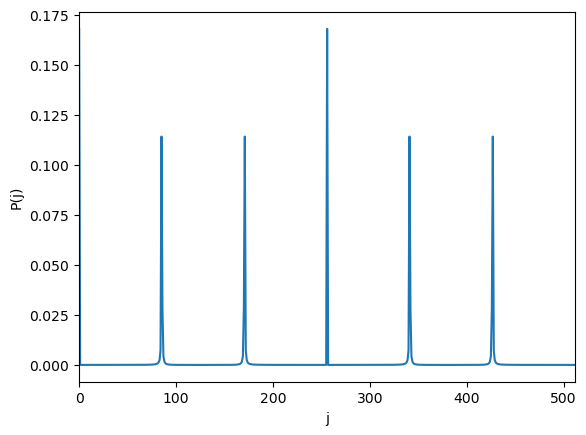

In [4]:
import matplotlib.pyplot as plt
N = 512
P = []
for j in range (N):
    s = 0
    for a in range(86):
        theta = -2*np.pi*6*j*a/float(512)
        s += complex(np.cos(theta), np.sin(theta))
    P.append((s.real **2  + s.imag ** 2)/float(86*512))
# print(P)
# the histogram of the data
plt.plot(range(N),P)
plt.xlim(0,N)
plt.xlabel('j')
plt.ylabel('P(j)')
plt.show()

We see 5 peaks achieved at the following points:

In [5]:
peaks = [i for i in range(N) if P[i] > 0.05]
print(peaks)

[0, 85, 171, 256, 341, 427]


If we measure $0$, we are out of luck, and have to re-run the algorithm. Suppose instead we measure $B=85$. Then, $\frac B{512}=\frac{85}{512}$, and we are supposed to figure out $r$ from here. Note that $\frac{85}{512}$ is a rational approximation of $\frac{k_0}{r}$, and so we can use the method of partial fractions to figure out $r$!

We do this as follows: 

In [6]:
import pandas as pd
import fractions

rows = []
for i in peaks:
    f = fractions.Fraction(i/512).limit_denominator(15)
    rows.append([i, f.denominator])
print(pd.DataFrame(rows, columns=["Peak", "Guess for r"]))

   Peak  Guess for r
0     0            1
1    85            6
2   171            3
3   256            2
4   341            3
5   427            6


If we guess $r=6$, we're good as that is the order of $2$ modulo $21$! However, if we stumble upon $2$ or $3$, we can easily check that $2^2$ and $2^3$ are not $1\mbox{ mod }21$, and continue running the algorithm recursively to find the order of $2^2$ or $2^3$, respectively.

## Conclusion
This gives us a complete picture of how Shor's algorithm works. 

We make one final remark, that the more qubits $t$ that we reserve in the first register, the better the accuracy of the algorithm becomes due to higher peaks.

## Further Reading and References

1. [Prof. Bernhard Ömer's Webpage](http://tph.tuwien.ac.at/~oemer/doc/quprog/node18.html)
2. [Markov-Saeedi: "Constant-Optimized Quantum Circuits for Modular Multiplication and Exponentiation"](https://arxiv.org/pdf/1202.6614.pdf)
3. [Quirk Circuit for Shor's Algorithm](tinyurl.com/8awfhrkd)
4. [Wikipedia page on Shor's Algorithm](https://en.wikipedia.org/wiki/Shor%27s_algorithm)
5. [IBM Composer Guide on Shor's Algorithm (in qiskit)](https://quantum-computing.ibm.com/composer/docs/iqx/guide/shors-algorithm)